In [30]:
%pip install duckdb
%pip install seaborn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [126]:
scale_factor = 10
xlsx_file_path = f'./tpch_customer_sf_{scale_factor}.xlsx'
result_file_path = f'./tpch_customer_sf_{scale_factor}_results.csv'
enable_create_tpch_xlsx = True
duckdb_executable_path = '../build/release/duckdb'
sheetreader_threads = [1,4]
runs_per_function = 5
enable_spatial_benchmarks = True

In [127]:
# %load tpch_writing.py
import duckdb

def create_tpch_xlsx(output_file_name, scale_factor=1, tpch_table_name="customer"):
    con = duckdb.connect(database = ":memory:")
    con.execute("INSTALL spatial;")
    con.execute("LOAD spatial;")
    con.execute("INSTALL tpch;")
    con.execute("LOAD tpch;")


    con.execute(f"CALL dbgen(sf = {scale_factor});")
    print(f"Created TPC-H data for scale factor {scale_factor}")

    all_cols = con.execute(f"DESCRIBE {tpch_table_name}").fetchall()

    decimal_columns = []

    for column in all_cols:
        column_name = column[0]
        column_type = column[1]

        if 'DECIMAL' in column_type:
            decimal_columns.append(column_name)

    for column in decimal_columns:
        col_name = column
        bigint_col_name = f"{col_name}_bigint"
        con.execute(f"ALTER TABLE {tpch_table_name} ADD COLUMN {bigint_col_name} BIGINT;")
        con.execute(f"UPDATE {tpch_table_name} SET {bigint_col_name} = CAST({col_name} AS BIGINT);")
        con.execute(f"ALTER TABLE {tpch_table_name} DROP COLUMN {col_name};")
        con.execute(f"ALTER TABLE {tpch_table_name} RENAME COLUMN {bigint_col_name} TO {col_name};")

    con.execute(f"COPY (SELECT * FROM {tpch_table_name}) TO '{output_file_name}' WITH (FORMAT GDAL, DRIVER 'xlsx');")

    con.close()


In [128]:
import os
if not os.path.isfile(xlsx_file_path):
  create_tpch_xlsx(xlsx_file_path, scale_factor)
else:
  print(f"Skipping creation of TPC-H data for scale factor {scale_factor}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created TPC-H data for scale factor 10


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [129]:
import timeit
import pandas as pd
import subprocess

def run_st_read(xlsx_file_path, runs_per_query=1, sheetreader_threads=[1]):
    results = pd.DataFrame(columns=['function', 'time'])

    def run(fn, fn_name):
        results.loc[len(results)] = [fn_name, timeit.timeit(fn, number=1)]
    def run_query(query):
        subprocess.run([duckdb_executable_path], input=query.encode(), stdout=subprocess.PIPE)
    def run_st_read():
        sql_stmt = f"load spatial; create table tmp_sp as from st_read('{xlsx_file_path}');"
        # Run ./duckdb_local with sql_stmt as input
        run_query(sql_stmt)
    def run_sheetreader(threads=1):
        sql_stmt = f"load sheetreader; create table tmp_sr as from sheetreader('{xlsx_file_path}', threads={threads});"
        # Run ./duckdb_local with sql_stmt as input
        return lambda : run_query(sql_stmt)

    run_query(f"install spatial;")

    for i in range(runs_per_query):
        print(f"Run {i+1}/{runs_per_query}")
        if enable_spatial_benchmarks:
            print(f"Run {i+1}/{runs_per_query} - st_read")
            run(run_st_read, 'Spatial')
        for thread in sheetreader_threads:
            print(f"Run SheetReader {i+1}/{runs_per_query} - SheetReader with {thread} threads")
            run(run_sheetreader(thread), f'SheetReader {thread} Thread{"s" if thread > 1 else ""}')

    return results


In [130]:
results = run_st_read(xlsx_file_path, runs_per_function, sheetreader_threads)

Run 1/5
Run 1/5 - st_read
Run SheetReader 1/5 - SheetReader with 1 threads
Run SheetReader 1/5 - SheetReader with 4 threads
Run 2/5
Run 2/5 - st_read
Run SheetReader 2/5 - SheetReader with 1 threads
Run SheetReader 2/5 - SheetReader with 4 threads
Run 3/5
Run 3/5 - st_read
Run SheetReader 3/5 - SheetReader with 1 threads
Run SheetReader 3/5 - SheetReader with 4 threads
Run 4/5
Run 4/5 - st_read
Run SheetReader 4/5 - SheetReader with 1 threads
Run SheetReader 4/5 - SheetReader with 4 threads
Run 5/5
Run 5/5 - st_read
Run SheetReader 5/5 - SheetReader with 1 threads
Run SheetReader 5/5 - SheetReader with 4 threads


In [131]:
# Save dataframe to csv
import time

# results.to_csv(f"results_sf_{scale_factor}_{int(time.time())}.csv")
results.to_csv(result_file_path)

    Unnamed: 0               function       time
0            0                Spatial  85.975069
1            1   SheetReader 1 Thread  30.615816
2            2  SheetReader 4 Threads  14.141709
3            3                Spatial  86.268932
4            4   SheetReader 1 Thread  28.927294
5            5  SheetReader 4 Threads  14.446914
6            6                Spatial  84.923233
7            7   SheetReader 1 Thread  29.267104
8            8  SheetReader 4 Threads  14.090325
9            9                Spatial  85.492440
10          10   SheetReader 1 Thread  29.322267
11          11  SheetReader 4 Threads  14.052366
12          12                Spatial  86.035383
13          13   SheetReader 1 Thread  29.225902
14          14  SheetReader 4 Threads  14.108776


/tmp/ipykernel_3392/2756422923.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


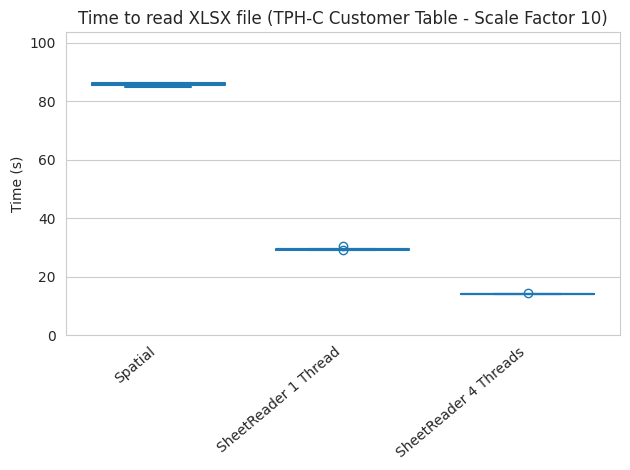

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# load the results from the csv
results = pd.read_csv(result_file_path)
print(results)
sns.set_style("whitegrid")
plot_title = f"Time to read XLSX file (TPH-C Customer Table - Scale Factor {scale_factor})"
ax = sns.boxplot(data=results, x="function", y="time", fill=False, gap=.1)
ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylim=(0, max(results['time']) * 1.2))
# Change ascpect ratio of the plot
# ax.set_aspect(1)

# Save the plot to a file
figure = ax.get_figure()
plt.tight_layout()
plt.savefig(f'benchmark_sf_{scale_factor}_{"with" if enable_spatial_benchmarks else "without"}_spatial.png')
plt.show()